In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.ticker import NullFormatter
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib
import datetime
import pickle
import os

<h2>1-reading segment table</h2>

In [2]:
#schema of segment table
schema_segments ='deviceId String,\
                  type Integer,\
                  dateTime string,\
                  startLatitude double,\
                  startLongitude double,\
                  startEngineStatus Integer,\
                  startAccuracyDrop Integer,\
                  endAccuracyDrop Integer,\
                  endEngineStatus Integer,\
                  endLatitude double,\
                  endLongitude double,\
                  segmentDistance double,\
                  segmentDuration double,\
                  segmentSpeedKmH double,\
                  xtmp double,\
                  ytmp double,\
                  start_x integer,\
                  start_y integer,\
                  end_x integer,\
                  end_y integer,\
                  cell_id_start string,\
                  cell_id_end string'
#reading csv
path = os.path.abspath(os.getcwd())
df_segments = spark.read.csv('file:///%s/segment_table'%path,sep=",", schema = schema_segments)

In [3]:
df_segments.count()

300841429

In [3]:
df_segments = df_segments.withColumn('dateTime', F.to_timestamp('dateTime'))
# df_segments.count()
df_segments.limit(10).show()

+--------+----+-------------------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
|deviceId|type|           dateTime|startLatitude|startLongitude|startEngineStatus|startAccuracyDrop|endAccuracyDrop|endEngineStatus|endLatitude|endLongitude|segmentDistance|segmentDuration|   segmentSpeedKmH|              xtmp|              ytmp|start_x|start_y|end_x|end_y|cell_id_start|cell_id_end|
+--------+----+-------------------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
| 4310385|   1|2019-03-07 08:19:17|     45.08231|      7.666967|                1|               

In [17]:
df_segments.select('deviceId').distinct().count()

288940

In [4]:
'''date extraction'''
#creating a new dataframe consisting only dates and their number
#of segments per date
dates = df_segments.withColumn('dateTime', F.to_date('dateTime'))

In [5]:
# dates = dates.select("dateTime").distinct()
dates.show()

+--------+----+----------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
|deviceId|type|  dateTime|startLatitude|startLongitude|startEngineStatus|startAccuracyDrop|endAccuracyDrop|endEngineStatus|endLatitude|endLongitude|segmentDistance|segmentDuration|   segmentSpeedKmH|              xtmp|              ytmp|start_x|start_y|end_x|end_y|cell_id_start|cell_id_end|
+--------+----+----------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
| 2506913|   2|2019-01-14|      45.0721|       7.70783|                1|                1|              1|              1| 

In [6]:
dates = dates.groupby('dateTime').agg(F.count('dateTime'))

In [7]:
dates = dates.sort('dateTime')
# dates.show()

In [8]:
dates = dates.filter(dates['dateTime'] >= '2019-01-01')

In [9]:
dates.show()

[Stage 4:==================================================>   (188 + 12) / 200]

+----------+---------------+
|  dateTime|count(dateTime)|
+----------+---------------+
|2019-01-01|            932|
|2019-01-02|           1867|
|2019-01-03|           2108|
|2019-01-04|           2528|
|2019-01-05|           1874|
|2019-01-06|           1284|
|2019-01-07|           2795|
|2019-01-08|           3136|
|2019-01-09|           3523|
|2019-01-10|           4167|
|2019-01-11|           4520|
|2019-01-12|           3325|
|2019-01-13|           4477|
|2019-01-14|         758354|
|2019-01-15|        1071770|
|2019-01-16|        1107370|
|2019-01-17|        1083332|
|2019-01-18|        1141061|
|2019-01-19|         820630|
|2019-01-20|         641671|
+----------+---------------+
only showing top 20 rows



In [10]:
dates = dates.toPandas()

In [11]:
dates.columns = ['date','num_segments']

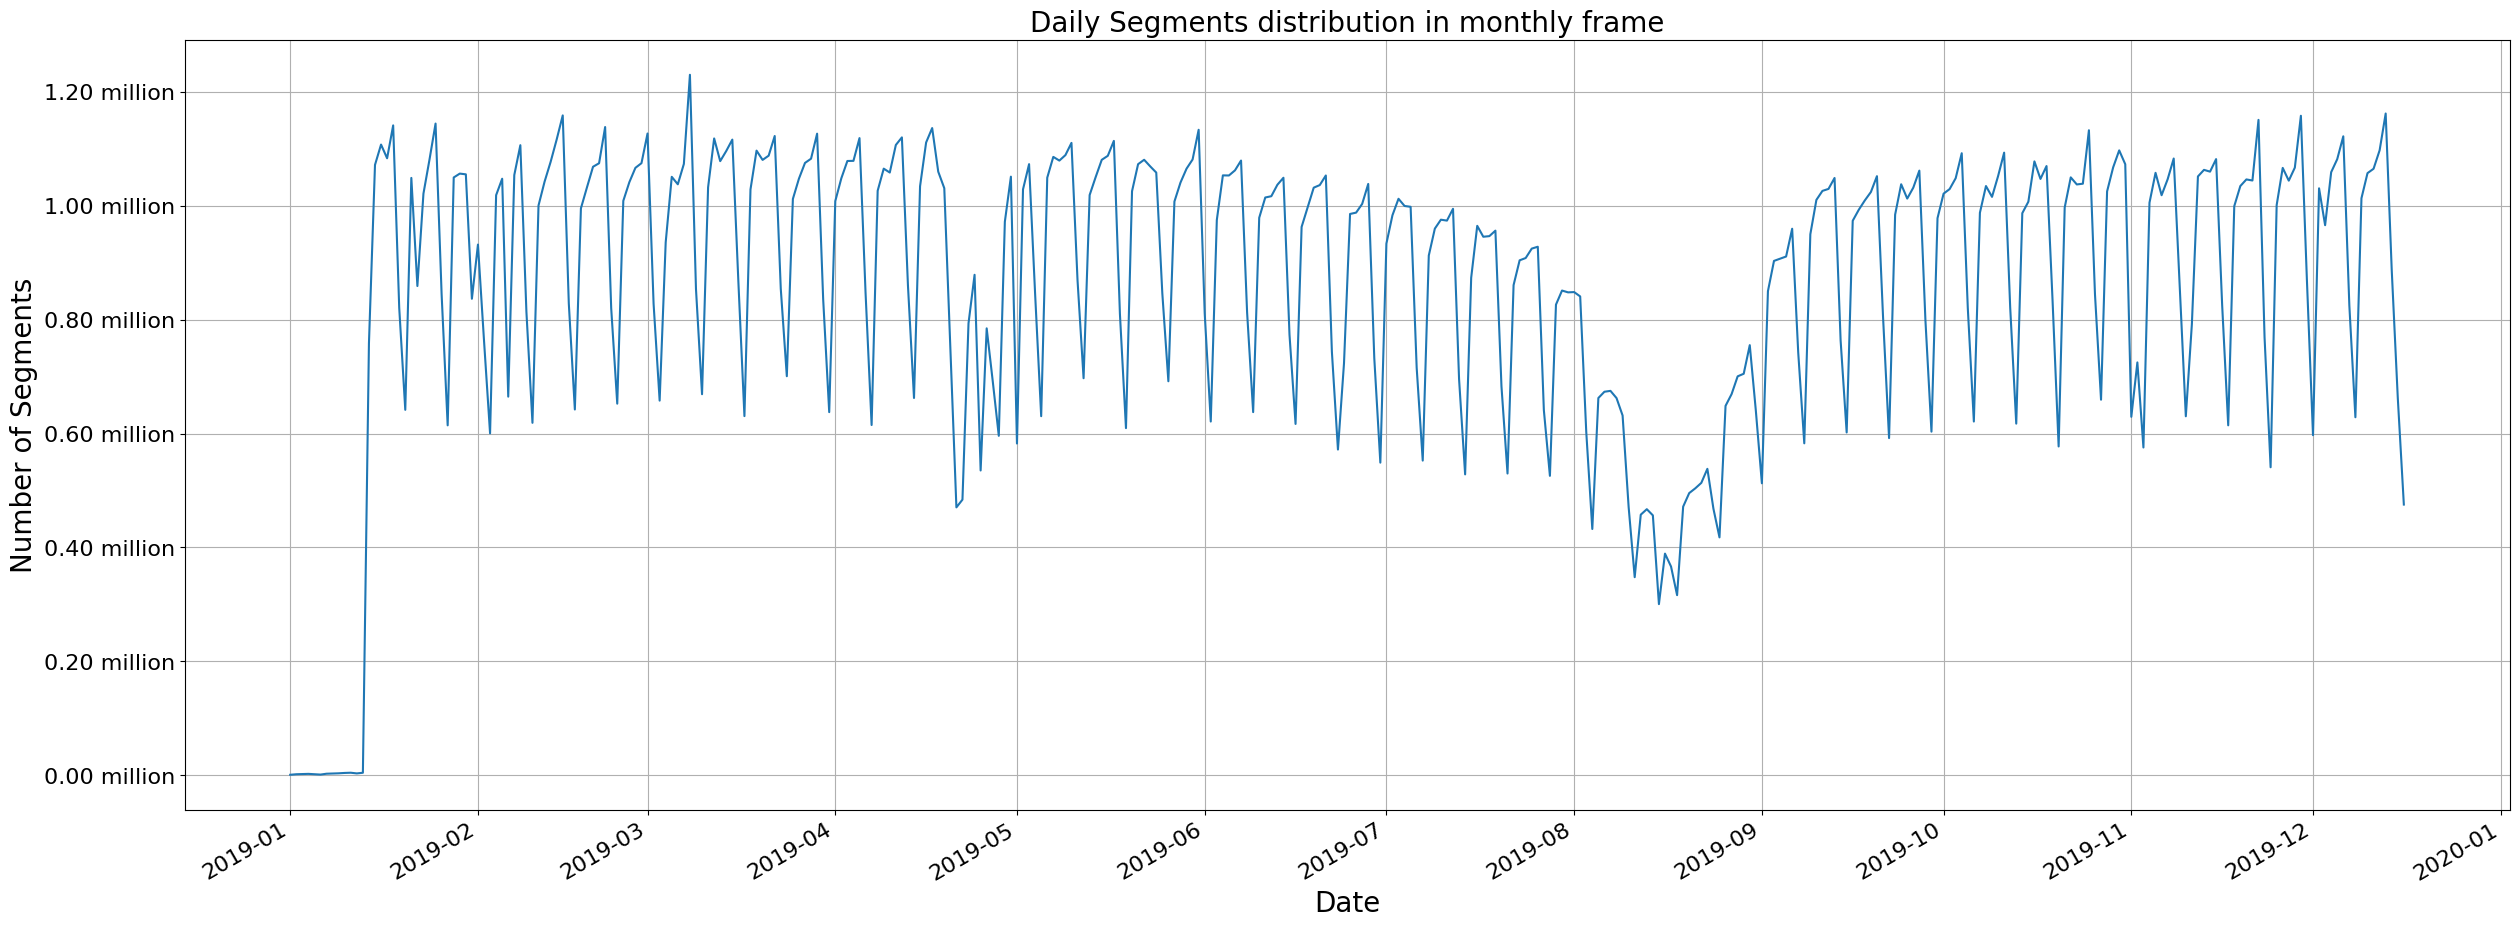

In [22]:
'''plot distribution oer dates'''
plt.rcParams["figure.figsize"] = (30,10)

plt.plot(dates['date'],dates['num_segments'], alpha = 1)
# locator = mdate.DayLocator()
locator = mdate.MonthLocator(interval = 1)
plt.gca().xaxis.set_major_locator(locator)

def formatter(x, pos):
    return str("{0:.2f}".format(x / 1e6)) + " million"

plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks(fontsize=16)

# plt.xlim('2019-01-01')
# plt.ylim(-10000,1200000)
plt.grid(True)
# plt.gca().set_axisbelow(True)
plt.xlabel("Date",fontsize=20)
plt.ylabel("Number of Segments", fontsize=20)
title = "Daily Segments distribution in monthly frame"
plt.title(title,fontsize=20)
plt.setp(plt.gca().get_xticklabels(), rotation=30, ha='right',fontsize=16)

plt.savefig(f'{title}_large.jpg',bbox_inches='tight')
plt.show()

In [36]:
dates.to_csv('all_dates.csv')